In [1]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
import tensorflow as tf
from sklearn.model_selection import train_test_split
from KernelCombinations import basic_combinations
import logging
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from SupportVectorMachine import rotate_SV, translate_SV

tf.enable_eager_execution()
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(0)

### Generate artificial dataset

In [2]:
n = 800
total_samples = n * 3
test_ratio = 0.90
num_train = int(round(total_samples * (1 - test_ratio)))
num_test = int(round(total_samples * test_ratio))
gamma = 0

L = 30
X = np.zeros((n * 3, L, L))
Y = np.zeros(n * 3)

for i in range(0, n):
    x1 = np.random.randint(0, 11)
    x2 = np.random.randint(10, 21)
    x3 = np.random.randint(20, 30)

    l1 = np.random.randint(3, 8)
    l2 = np.random.randint(3, 8)
    l3 = np.random.randint(3, 8)

    y1 = np.random.randint(0, L - l1)
    y2 = np.random.randint(0, L - l2)
    y3 = np.random.randint(0, L - l3)

    X[i, y1:y1 + l1, x1] = 1
    X[i + n, y2:y2 + l2, x2] = 1
    X[i + 2 * n, y3:y3 + l3, x3] = 1

X = X.reshape(3 * n, L * L)

Y[0:n] = 0
Y[n:2 * n] = 1
Y[2 * n:3 * n] = 2

### Check some training samples

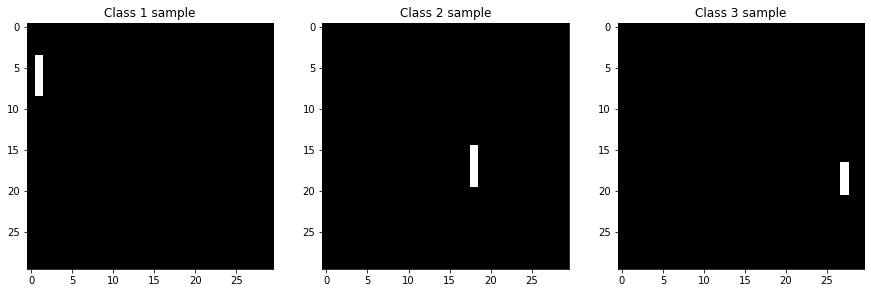

In [3]:
plt.figure(figsize=(15, 5))

for i in range(0, 3):
    sample = X[np.random.randint(i*n, (i+1)*n)]
    sample[sample == 1] = 255
    img = Image.fromarray(sample.reshape(L, L)).convert('RGB')
    
    plt.subplot(131 + i)
    plt.imshow(img)
    plt.title(f"Class {i+1} sample")

plt.show()

### Define pooling kernel

In [4]:
def pooling_kernel(x_matrix, y_matrix):
    num_features = x_matrix.shape[1]
    sqrt_features = int(np.sqrt(num_features))
    x_length = x_matrix.shape[0]
    y_length = y_matrix.shape[0]

    gram_matrix = rbf_kernel(x_matrix, y_matrix, gamma=A_gamma)

    x_reshaped = x_matrix.reshape(x_length, sqrt_features, sqrt_features, 1)
    y_reshaped = y_matrix.reshape(y_length, sqrt_features, sqrt_features, 1)

    max_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                         strides=1)
    filtered_x = max_pool(x_reshaped).numpy() \
        .reshape(x_length,
                 np.square(int(sqrt_features - 1)))
    filtered_y = max_pool(y_reshaped).numpy() \
        .reshape(y_length,
                 np.square(int(sqrt_features - 1)))

    pooled_matrix = rbf_kernel(filtered_x, filtered_y, gamma=B_gamma)

    max_pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                          strides=1)
    filtered_x_2 = max_pool2(x_reshaped).numpy() \
        .reshape(x_length,
                 np.square(int(sqrt_features - 2)))
    filtered_y_2 = max_pool2(y_reshaped).numpy() \
        .reshape(y_length,
                 np.square(int(sqrt_features - 2)))

    pooled_matrix_2 = rbf_kernel(filtered_x_2, filtered_y_2, gamma=C_gamma)

    A = gram_matrix
    B = pooled_matrix
    C = pooled_matrix_2

    gram_matrix = combiner(A, B, C)
    return gram_matrix

In [5]:
def test_error(model, features, labels):
    error = (1.0 - accuracy_score(labels, model.predict(features))) * 100
    return np.around(error, decimals=2)

### Run SVM with pooling kernel

In [20]:
gammas = np.logspace(-3.5, -0.65, 7)
num_runs = 1

errors = np.zeros((len(basic_combinations), len(gammas)))
VSV_errors = np.zeros(len(gammas))

for rstate in range(0, num_runs):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio,
                                                        random_state=rstate)
    
    # Test the pooling kernel 
    for i, f in enumerate(basic_combinations):
        combiner = f
        current_errors = []
        for g in gammas:
            A_gamma = B_gamma = C_gamma = g
            model = svm.SVC(C=2, cache_size=50, kernel=pooling_kernel)
            model.fit(X_train, Y_train)
            current_errors.append(test_error(model, X_test, Y_test))
        errors[i] += np.asarray(current_errors)
    
    # Test VSV method
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    X_train, Y_train = translate_SV(X_train, directions, 1, 1, Y_train)
    combiner = basic_combinations[0]
    current_errors = []
    for g in gammas:
        A_gamma = B_gamma = C_gamma = g
        model = svm.SVC(C=2, cache_size=50, kernel=pooling_kernel)
        model.fit(X_train, Y_train)
        current_errors.append(test_error(model, X_test, Y_test))
    VSV_errors += np.asarray(current_errors)

# VSV_errors = VSV_errors / num_runs
errors = errors / num_runs

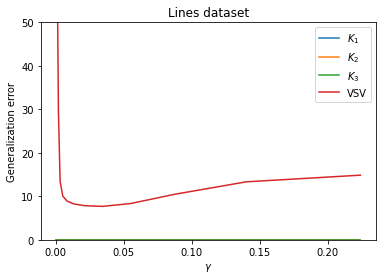

In [16]:
plt.clf()
plt.ylim(0, 50)
plt.plot(gammas, errors[0], label='RBF')
plt.plot(gammas, errors[1], label='Pooling 2x2')
plt.plot(gammas, errors[2], label='$Pooling 3x3$')
plt.plot(gammas, VSV_errors, label='VSV')
plt.title(f"Artificial Lines dataset")
plt.legend(loc='upper right')
plt.xlabel("$\gamma$")
plt.ylabel("Generalization error")
# plt.savefig("kernel-comparison.png", dpi=400)
plt.show()

### Plot learning curves

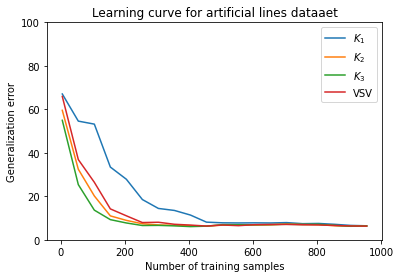

In [42]:
index = np.argmin(errors)
A_gamma = B_gamma = C_gamma = gammas[index % len(gammas)]
samples = range(5, 1000, 50)
num_runs = 1

LC_errors = np.zeros((len(basic_combinations), len(samples)))
VSV_LC_errors = np.zeros(len(samples))

for rstate in range(0, num_runs):

    for i, num in enumerate(samples):

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=3*n-num,
                                                            random_state=rstate)
        # Test the pooling kernel
        for j, f in enumerate(basic_combinations):
            combiner = f
            model = svm.SVC(C=2, cache_size=50, kernel=pooling_kernel)
            model.fit(X_train, Y_train)
            LC_errors[j][i] += test_error(model, X_test, Y_test)
            
        # Test VSV method
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]
        X_train, Y_train = translate_SV(X_train, directions, 1, 1, Y_train)
        combiner = basic_combinations[0]
        model = svm.SVC(C=2, cache_size=50, kernel=pooling_kernel)
        model.fit(X_train, Y_train)
        VSV_LC_errors[i] += test_error(model, X_test, Y_test)

LC_errors = LC_errors / num_runs
VSV_LC_errors = VSV_LC_errors / num_runs

plt.clf()
plt.ylim(0, 100)
plt.plot(samples, LC_errors[0], label='$K_1$')
plt.plot(samples, LC_errors[1], label='$K_2$')
plt.plot(samples, LC_errors[2], label='$K_3$')
plt.plot(samples, VSV_LC_errors, label='VSV')
plt.title(f"Learning curve for artificial lines dataaet")
plt.legend(loc='upper right')
plt.xlabel("Number of training samples")
plt.ylabel("Generalization error")
plt.savefig("learning-curve.png", dpi=400)
plt.show()